# Time Series Forecasting with SARIMAX (Final Model)

This notebook implements a SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) model to forecast team-level win percentage (`WL%`) in Major League Baseball.

We model each team's historical performance using:
- Autoregressive time-series dynamics
- Key predictors like OPS and ERA
- Lagged variables and diagnostic checks

This version reflects the **finalized model** submitted for the project and includes:
- Team-by-team SARIMAX modeling
- VIF analysis for predictor multicollinearity
- Model interpretation and forecasting

Data Source: `baseball-data.csv` (previously called 'BaseballData590.csv')

# Libraries

In [ ]:
import numpy as np # for data manipulation
import pandas as pd # for numeric operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX  # for SARIMAX model
from statsmodels.tsa.stattools import adfuller          # for stationarity test (ADF)
from statsmodels.tools.eval_measures import rmse        # for forecast error evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence \
import variance_inflation_factor as VIF
from statsmodels.tsa.stattools import grangercausalitytests

# Data

In [ ]:
# Loading our data frame
df = pd.read_csv('data/BaseballData590.csv', na_values=['?'])
# Visualizing a summary of the df
df = df.rename(columns={'WL%': 'WinPct'})
df.head()

,Season,Team,Lg,W,GP,L,WinPct,Bat#,PA,AB,...,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/BB
0,2001,SEA,AL,116,162,46,0.716,32,6474,5680,...,40,6096,117,4.12,1.200,7.9,1.0,2.9,6.5,2.26
1,1998,NYY,AL,114,162,48,0.704,32,6444,5643,...,37,6100,116,4.15,1.251,8.4,1.0,2.9,6.7,2.32
2,2022,LAD,NL,111,162,51,0.685,29,6247,5526,...,38,5865,145,3.45,1.048,6.9,0.9,2.5,9.1,3.60
3,2018,BOS,AL,108,162,54,0.667,40,6302,5623,...,51,6166,118,3.82,1.246,8.1,1.1,3.2,9.6,3.04
4,1986,NYM,NL,108,162,54,0.667,36,6349,5558,...,40,6165,115,3.31,1.221,7.9,0.6,3.1,6.6,2.13


# Time Series

In [ ]:
# Counting the amount of teams
team_names = df['Team'].unique()
num_teams = len(team_names)
print(f"There are {num_teams} unique teams:")
print(sorted(team_names))

There are 35 unique teams:
['ANA', 'ARI', 'ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET', 'FLA', 'HOU', 'KCR', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TBD', 'TBR', 'TEX', 'TOR', 'WSN']


In [ ]:
# Grouping and listing teams per season
teams_by_year = df.sort_values('Season').groupby('Season')['Team'].unique()

for year, teams in teams_by_year.items():
    print(f"{year}: {sorted(teams)}")


1974: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SFG', 'STL', 'TEX']
1975: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SFG', 'STL', 'TEX']
1976: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SFG', 'STL', 'TEX']
1977: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TEX', 'TOR']
1978: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TEX', 'TOR']
1979: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL',

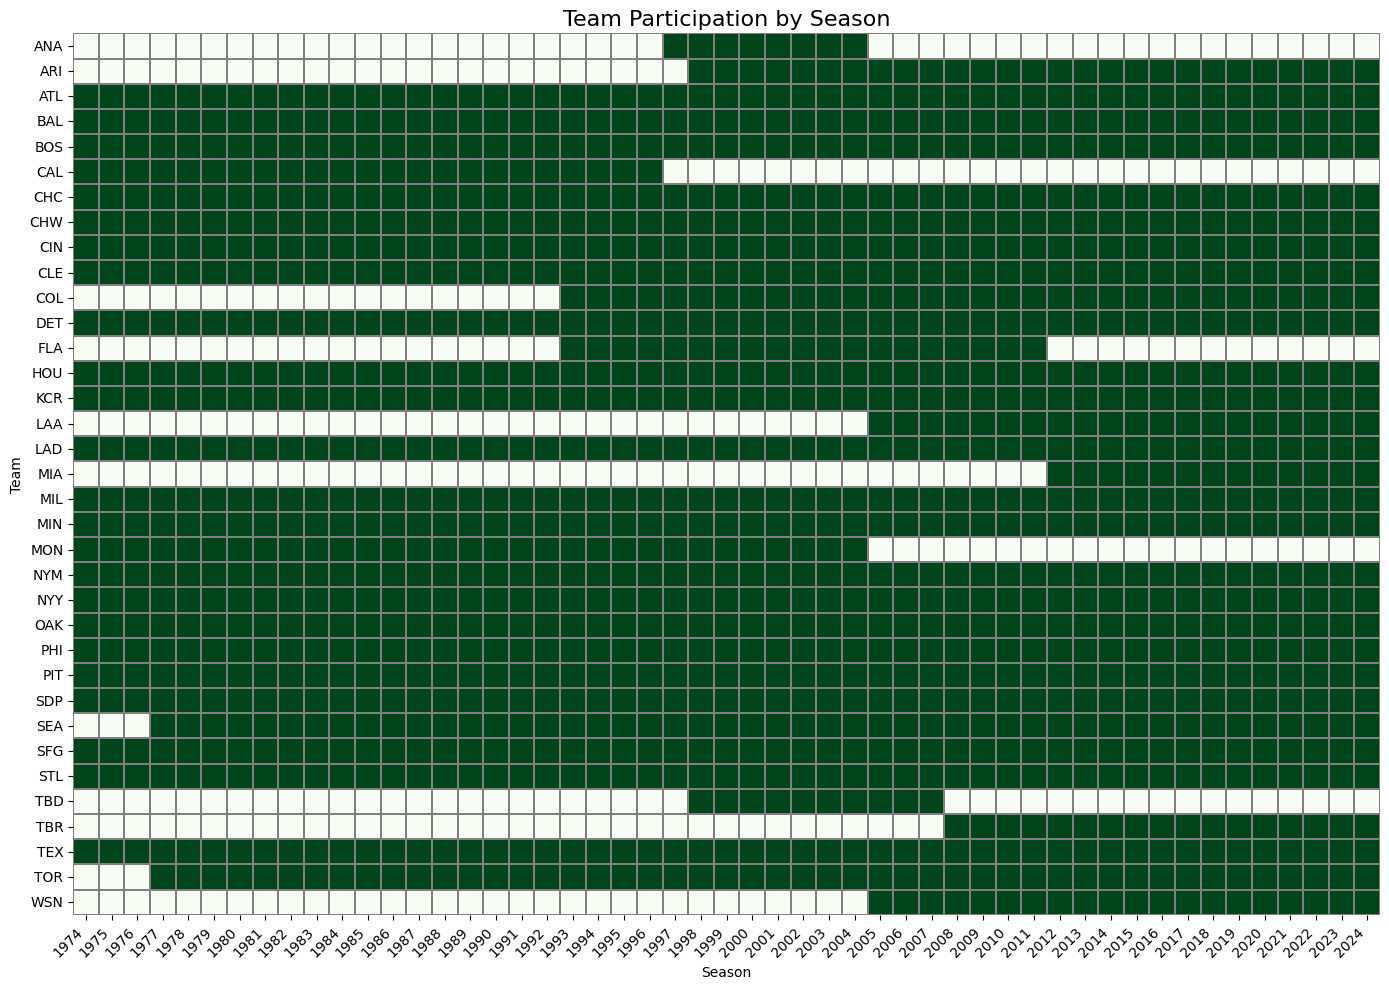

In [ ]:
# Creating a pivot table of Team x Season
team_year_matrix = (
    df[['Season', 'Team']]
    .drop_duplicates()
    .assign(value=1)
    .pivot(index='Team', columns='Season', values='value')
    .fillna(0)
)

# Sorting rows alphabetically, and columns chronologically
team_year_matrix = team_year_matrix.sort_index().sort_index(axis=1)

# Plotting the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(team_year_matrix, cmap='Greens', cbar=False, linewidths=0.2, linecolor='gray')

plt.title("Team Participation by Season", fontsize=16)
plt.xlabel("Season")
plt.ylabel("Team")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Team Name Standardization

In [ ]:
df['Team'] = df['Team'].replace({
    'MON': 'WSN',
    'ANA': 'LAA',
    'FLA': 'MIA',
    'TBD': 'TBR',
    'CAL': 'LAA'
})


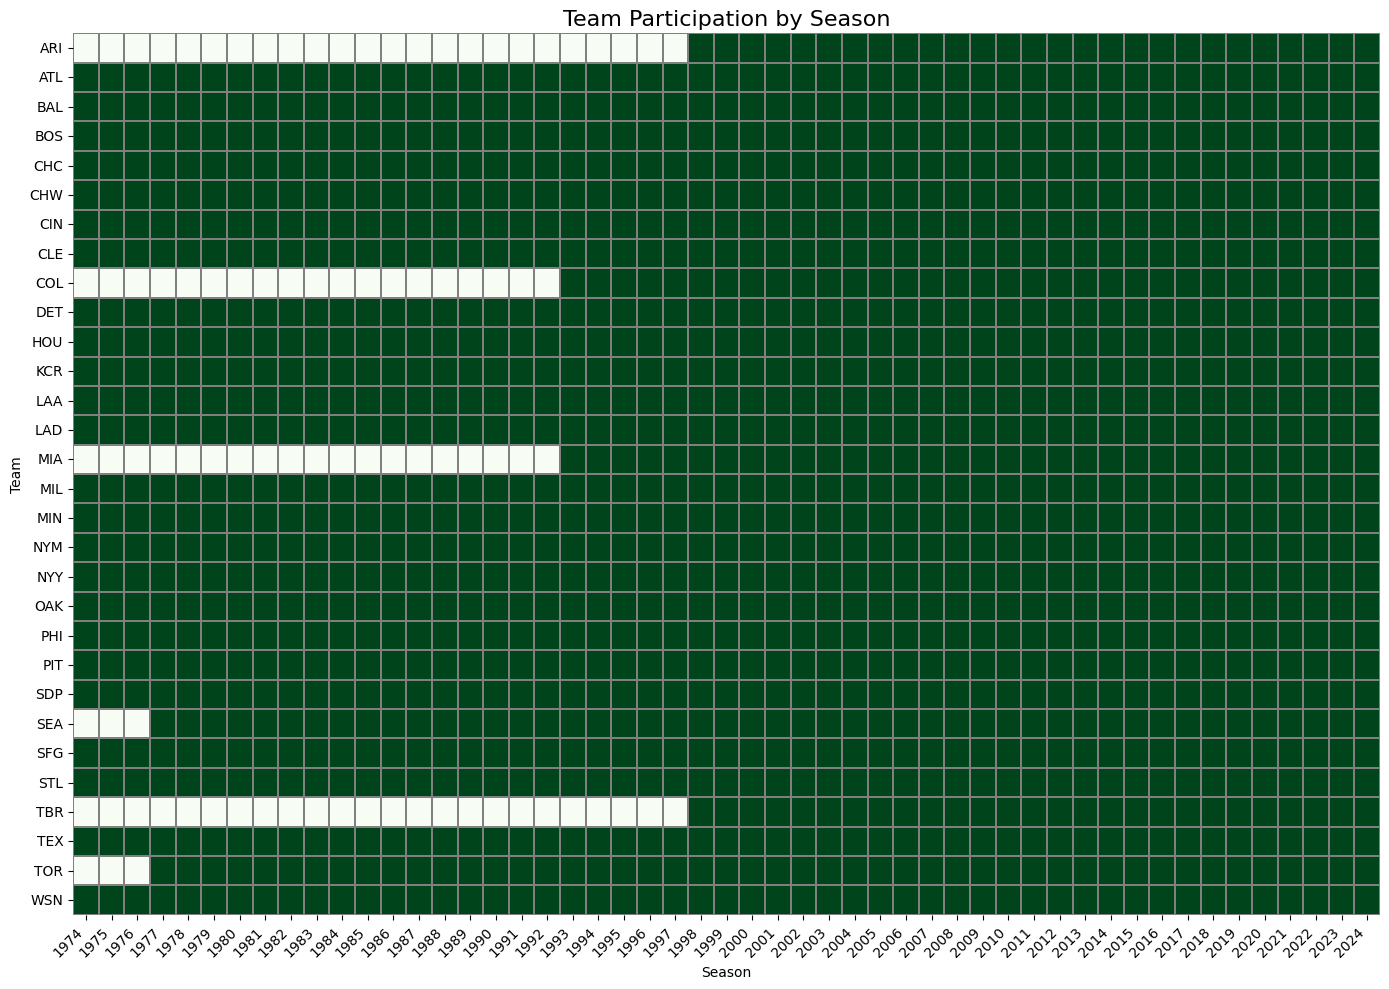

In [ ]:
team_year_matrix = (
    df[['Season', 'Team']]
    .drop_duplicates()
    .assign(value=1)
    .pivot(index='Team', columns='Season', values='value')
    .fillna(0)
)

# 2. Sort rows alphabetically, and columns chronologically
team_year_matrix = team_year_matrix.sort_index().sort_index(axis=1)

# 3. Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(team_year_matrix, cmap='Greens', cbar=False, linewidths=0.2, linecolor='gray')

plt.title("Team Participation by Season", fontsize=16)
plt.xlabel("Season")
plt.ylabel("Team")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## First SARIMAX model 

### Step 1: Preparing Yankee Time Series Data

In [ ]:
# Filtering just the Yankees and sorting by season
yankees_df = df[df['Team'] == 'NYY'].sort_values('Season').reset_index(drop =  True)

# Selecting key columns: target (WinPct) and two predictors (e.g. ERA, OPS)
cols_to_use = ['Season', 'WinPct', 'ERA', 'OPS']
yankees_df = yankees_df[cols_to_use].dropna()

# Shifting predictors one year back so we only use past data to predict next season
yankees_df['ERA_lag'] = yankees_df['ERA'].shift(1)
yankees_df['OPS_lag'] = yankees_df['OPS'].shift(1)

# Dropping the first row (which now has NaNs in lagged predictors)
yankees_df = yankees_df.dropna().reset_index(drop=True)

# Preview the cleaned dataset
print(yankees_df.head())

   Season  WinPct   ERA    OPS  ERA_lag  OPS_lag
0    1975   0.519  3.29  0.707     3.32    0.692
1    1976   0.610  3.19  0.716     3.29    0.707
2    1977   0.617  3.63  0.788     3.19    0.716
3    1978   0.613  3.18  0.718     3.63    0.788
4    1979   0.556  3.85  0.733     3.18    0.718


### Step 2. Checking for Stationarity

In [ ]:
# Runing the ADF test on the WinPct series
result = adfuller(yankees_df['WinPct'])

# Printing the test statistic and p-value
print("ADF Test Statistic:", result[0])
if result[1] < 0.05:
    print("our p-value:", result[1], "is less than 0.05")
else:
    print("our p-value:", result[1], "is greater than 0.05")



ADF Test Statistic: -3.9706352720852878
our p-value: 0.0015723244592452962 is less than 0.05


### Step 3. Fit the SARIMAX model

In [ ]:
# Defining the target and exogenous variables
y = yankees_df['WinPct']
X = yankees_df[['ERA_lag', 'OPS_lag']]

# Defining and fit the SARIMAX model
model = SARIMAX(endog=y, exog=X, order=(1, 0, 1))
results = model.fit()

# Printing the summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 WinPct   No. Observations:                   50
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  81.309
Date:                Mon, 21 Apr 2025   AIC                           -152.618
Time:                        22:21:35   BIC                           -143.058
Sample:                             0   HQIC                          -148.977
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ERA_lag       -0.0624      0.020     -3.133      0.002      -0.101      -0.023
OPS_lag        1.0688      0.104     10.286      0.000       0.865       1.272
ar.L1          0.2767      0.449      0.617      0.5

## Generalizing our model

In [ ]:
# Initiliazing results
results = []

# Looping through each team
for team in df['Team'].unique():
    team_df = df[df['Team'] == team].sort_values('Season').reset_index(drop=True)

    # Skip if missing data
    if team_df[['WinPct', 'ERA', 'OPS']].isnull().any().any():
        continue

    # Add lagged predictors
    team_df['ERA_lag'] = team_df['ERA'].shift(1)
    team_df['OPS_lag'] = team_df['OPS'].shift(1)
    team_df = team_df.dropna().reset_index(drop=True)

    total_rows = len(team_df)

    # Split by index (chronologically): 80% train, 20% test
    split_idx = int(total_rows * 0.8)
    train = team_df.iloc[:split_idx]
    test = team_df.iloc[split_idx:]

    y_train = train['WinPct']
    X_train = train[['ERA_lag', 'OPS_lag']]
    y_test = test['WinPct']
    X_test = test[['ERA_lag', 'OPS_lag']]

    try:
        # Fitting SARIMAX model
        model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        
        # Predicting on test set
        pred = model_fit.predict(start=test.index[0], end=test.index[-1], exog=X_test)
        
        # Calculating errors
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)

        # To store results
        results.append({
            'Team': team,
            'Test RMSE': round(rmse, 4),
            'Test MAE': round(mae, 4),
            'Train Size': len(train),
            'Test Size': len(test)
        })

    except Exception as e:
        print(f"Model failed for {team}: {e}")

# Creat inga results dataframe
results_df2 = pd.DataFrame(results).sort_values('Test RMSE')

results_df2.reset_index(drop=True, inplace=True)
results_df2

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\st

,Team,Test RMSE,Test MAE,Train Size,Test Size
0,PHI,0.0381,0.0348,40,10
1,LAA,0.0428,0.0313,40,10
2,NYY,0.0524,0.0469,40,10
3,ATL,0.0547,0.0489,40,10
4,STL,0.0584,0.0462,40,10
5,TOR,0.0584,0.0502,37,10
6,LAD,0.0600,0.0528,40,10
7,PIT,0.0620,0.0506,40,10
8,CIN,0.0645,0.0527,40,10
9,COL,0.0671,0.0573,24,7


In [ ]:
# Computing the average (mean) Test RMSE across all teams
average_rmse = results_df2['Test RMSE'].mean()
print(f"Average Test RMSE across all teams: {average_rmse:.4f}")

Average Test RMSE across all teams: 0.0715


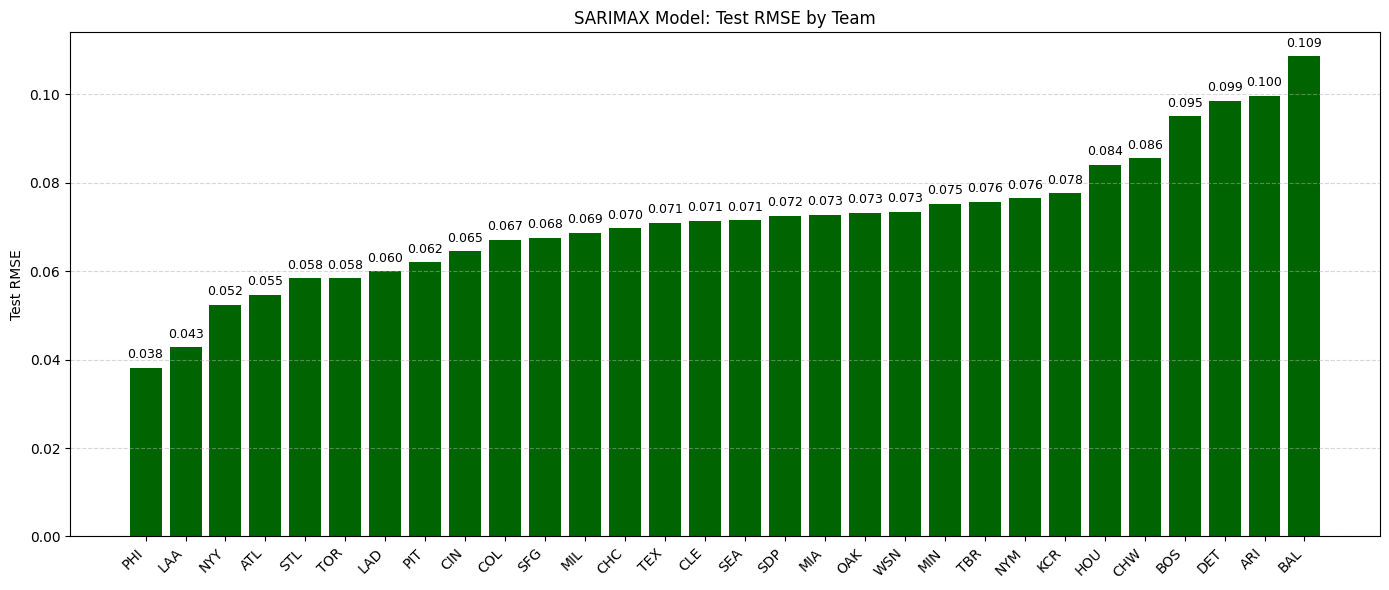

In [ ]:
# Creating the bar chart
plt.figure(figsize=(14, 6))
bars = plt.bar(results_df2['Team'], results_df2['Test RMSE'], color='darkgreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test RMSE')
plt.title('SARIMAX Model: Test RMSE by Team')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotating each bar with its height
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.0015, f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)


plt.tight_layout()
plt.show()

## Rolling Window Apaproach

In [ ]:
# Loading  full dataset
df = pd.read_csv('data/BaseballData590.csv')  # Replace with your actual file path if different

# Renaming the win percentage column 
df = df.rename(columns={'WL%': 'WinPct'})

# Filtering for the New York Yankees and sort by season
yankees_df = df[df['Team'] == 'NYY'].sort_values('Season').reset_index(drop=True)

# Defining the predictors we're using
predictors = ['OPS', 'ERA', 'PA', 'R', 'LOB', 'IP', 'WHIP', 'OBP']

# Defining the columns to keep
cols_to_use = ['Season', 'WinPct'] + predictors

# Creating the cleaned dataset by selecting and dropping rows with missing values
yankees_df = yankees_df[cols_to_use].dropna().reset_index(drop=True)

print(yankees_df.head())

## Univarite 

In [ ]:
# Setting rolling window size
window_size = 10

# Initializign structure to hold results
rolling_results = {var: [] for var in predictors}
seasons = []

# Looping through each rolling window
for start in range(len(team_df) - window_size + 1):
    end = start + window_size
    window = team_df.iloc[start:end]
    seasons.append(window['Season'].iloc[-1])  # season at the end of the window

    for var in predictors:
        X = sm.add_constant(window[[var]])
        y = window['WinPct']
        model = sm.OLS(y, X).fit()
        rolling_results[var].append(model.params[var])  # store coefficient

# Converting results to a DataFrame
rolling_df = pd.DataFrame(rolling_results)
rolling_df['Season'] = seasons
rolling_df = rolling_df[['Season'] + predictors]  # reorder columns

# Displaying results
print(rolling_df.head())

   Season       OPS       ERA        PA         R       LOB        IP  \
0    2003  3.138033 -0.152301  0.000018  0.000340  0.000171  0.000072   
1    2004  3.148179 -0.150582  0.000019  0.001698  0.000309  0.000067   
2    2005  3.166631 -0.152225  0.000107  0.002035  0.000578  0.000149   
3    2006  2.646841 -0.166406  0.000124  0.001886  0.000537  0.000117   
4    2007  1.506128 -0.152597 -0.000430  0.000880 -0.000193 -0.000830   

       WHIP       OBP  
0 -0.782969  7.572665  
1 -0.696434  7.359238  
2 -0.700768  7.267857  
3 -0.719876  7.380354  
4 -0.593139  7.105590  


## Multivariate

In [ ]:
# Setting rolling window size
window_size = 10

# Initialize result containers
rolling_results = {var: [] for var in predictors}
seasons = []

# Performing multivariate regression in rolling windows
for start in range(len(team_df) - window_size + 1):
    end = start + window_size
    window = team_df.iloc[start:end]
    seasons.append(window['Season'].iloc[-1])  # season ending the window

    X = sm.add_constant(window[predictors])
    y = window['WinPct']
    model = sm.OLS(y, X).fit()

    for var in predictors:
        rolling_results[var].append(model.params[var])

# Converting to DataFrame
rolling_df = pd.DataFrame(rolling_results)
rolling_df['Season'] = seasons
rolling_df = rolling_df[['Season'] + predictors]  # reordering columns

print(rolling_df.head())

   Season       OPS       ERA        PA         R       LOB        IP  \
0    2003 -1.601121  0.170468 -0.002221  0.002849  0.002529  0.006153   
1    2004 -0.331051 -0.010830 -0.001680  0.002113  0.001575  0.005155   
2    2005 -0.856388 -0.060633 -0.001088  0.001430  0.000461  0.002338   
3    2006 -2.760398  0.360504 -0.000083  0.002724 -0.000439  0.000495   
4    2007 -5.177718 -0.510633  0.002450  0.001360 -0.001272 -0.006827   

       WHIP        OBP  
0 -0.884804   0.755508  
1  0.015335   1.407110  
2  0.132167   5.234910  
3 -1.366407  14.209776  
4  0.609441   3.731145  


## VIF

In [ ]:
df = pd.read_csv('data/BaseballData590.csv')
df = df.rename(columns={'WL%': 'WinPct'})
team_df = df[df['Team'] == 'NYY'].sort_values('Season').reset_index(drop=True)

# Defining the predictors to check for multicollinearity
predictors = ['OPS', 'ERA', 'PA', 'R', 'LOB', 'IP', 'WHIP', 'OBP']

# Dropping missing values
team_df = team_df[predictors].dropna().reset_index(drop=True)

# Adding constant for VIF calculation
X = sm.add_constant(team_df)

# Computing VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [VIF(X.values, i) for i in range(X.shape[1])]

# Displaying results
print(vif_data)

  Variable           VIF
0    const  13800.428743
1      OPS     31.648781
2      ERA      5.680731
3       PA   4845.987634
4        R    177.269358
5      LOB    310.887385
6       IP   2168.992397
7     WHIP     10.290790
8      OBP     50.927611


In [ ]:
reduced_predictors = ['OPS', 'ERA']
# Choosing reduced predictor set
reduced_predictors = ['OPS', 'ERA']

# Dropping missing values
team_df = team_df[reduced_predictors].dropna().reset_index(drop=True)

# Adding constant for VIF calculation
X = sm.add_constant(team_df)

# Calculating VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [VIF(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  Variable         VIF
0    const  301.739664
1      OPS    1.201813
2      ERA    1.201813
